In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp
from IPython.display import SVG

from pydrake.geometry import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.solvers import MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
# from reproduction.prm_comparison.planning import PresplinedPRM
# from pydrake.all import (PRMPlannerCreationParameters, BiRRTPlannerParameters, PRMPlannerCreationParameters, PRMPlannerQueryParameters, PathProcessorParameters)
from reproduction.prm_comparison.helpers import (
    get_traj_length,
    InverseKinematics,
    make_traj,
    visualize_trajectory,
    plot_results,
    make_result_table,
)

# from pydrake.all import PRMPlanner,BiRRTPlanner
from itertools import combinations

# from pydrake.all import ChangeOmpNumThreadsWrapper

from reproduction.util import GcsDir, FindModelFile

mosek_license = MosekSolver.AcquireLicense()

In [2]:
# Start the visualizer (run this cell only once, each instanc|e consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
SEED = 0
np.random.seed(SEED)
# CORE_CNT = mp.cpu_count() # you may edit this.
CORE_CNT = 15

In [8]:
meshcat.Delete()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, shelf, binR, binL, table] = models
iiwa_idx = plant.GetModelInstanceByName("iiwa")
wsg_idx = plant.GetModelInstanceByName("wsg")

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat,
                                             meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

RuntimeError: error: URI 'package://drake/manipulation/models/iiwa_description/urdf/iiwa14_spheres_collision.urdf' resolved to '/home/savva/Desktop/drake_new/drake-build/install/share/drake/manipulation/models/iiwa_description/urdf/iiwa14_spheres_collision.urdf' which does not exist.

## IRIS Seeds

In [5]:
milestones = {
    "AS": [[0.75, 0, 0.9], [0, -np.pi, -np.pi / 2]],
    "TS": [[0.75, 0, 0.67], [0, -np.pi, -np.pi / 2]],
    "CS": [[0.75, 0, 0.41], [0, -np.pi, -np.pi / 2]],
    "LB": [[0.0, 0.6, 0.22], [np.pi / 2, np.pi, 0]],
    "RB": [[0.0, -0.6, 0.22], [np.pi / 2, np.pi, np.pi]]
}

additional_seed_points = {
    "C": np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi / 2]),
    "L": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2]),
    "R": np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2])
}

q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations = {
    name: InverseKinematics(q0, trans, rot)
    for name, (trans, rot) in milestones.items()
}

seed_points = {**milestone_configurations, **additional_seed_points}

# Load pre-generated regions

In [4]:
#load regions
# with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
#     regions = pickle.load(f)
with open(os.path.join(GcsDir(), "data/prm_comparison/final_regions_v2.pkl"), "rb") as f:
    regions = pickle.load(f)

# Or Regenerate IRIS Regions

Note: This IRIS region computation is slow. We give the option to load the pre-generated regions in the cells below; in which case you can skip this step.

## via manual seeds

In [ ]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.02
iris_options.num_collision_infeasible_samples = 1
iris_options.random_seed = SEED


In [ ]:
def calcRegion(seed, verbose):
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    try:
        hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    except Exception as e:
        print(f"Seed: {seed} failed with error: {e}")
        return None
    if verbose:
        print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly


def generateRegions(seed_points, verbose=True):
    seeds = list(
        seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    with mp.Pool(processes=min(CORE_CNT, len(seed_points))) as pool:
        regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))

    return regions

In [ ]:
regions = generateRegions(seed_points)

# Create the GCS Trajectory Optimization

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-01


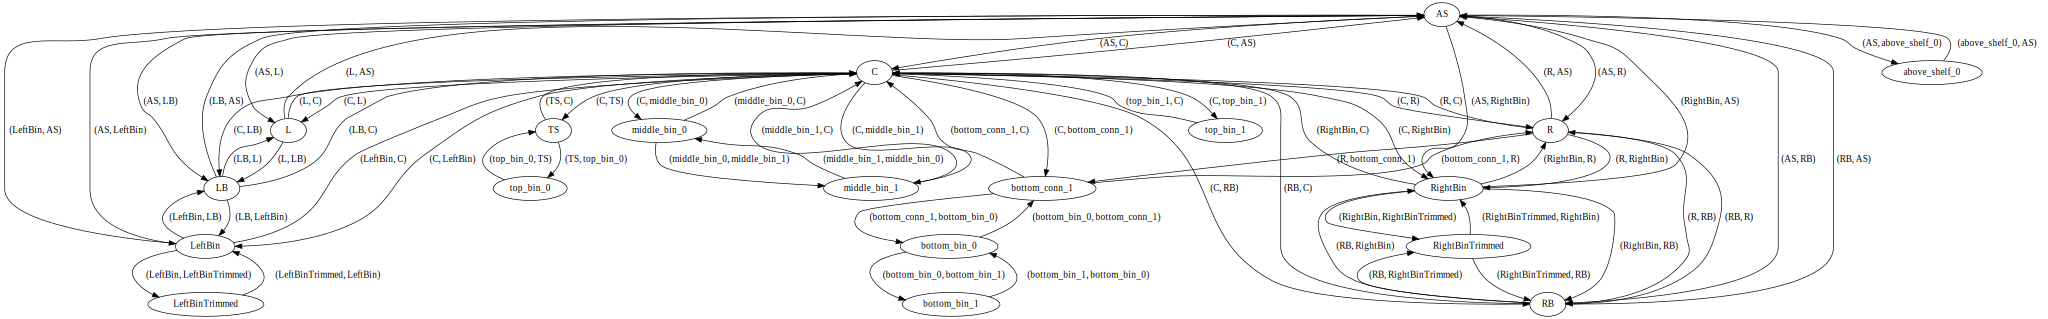

In [10]:
gcs = LinearGCS(regions)
SVG(gcs.VisualizeGraph()) 

In [5]:
def INFO(*texts, verbose: bool = True):
    if verbose:
        print(" ".join([str(text) for text in texts]))

class timeit:
    def __init__(self):
        self.times = []
        self.times.append(time.time())
        self.totals = 0
        self.a_start = None

    def dt(self, descriptor=None, print_stuff=True):
        self.times.append(time.time())
        if print_stuff:
            if descriptor is None:
                INFO("%.3fs since last time-check" % (self.times[-1] - self.times[-2]))
            else:
                descriptor = str(descriptor)
                INFO(descriptor + " took %.3fs" % (self.times[-1] - self.times[-2]))
        return self.times[-1] - self.times[-2]

    def T(self, descriptor=None):
        self.times.append(time.time())
        if descriptor is None:
            INFO("%.3fs since the start" % (self.times[-1] - self.times[0]))
        else:
            INFO(descriptor + " took %.3fs since the start" % (self.times[-1] - self.times[0]))

    def start(self):
        self.a_start = time.time()

    def end(self):
        self.totals += time.time() - self.a_start
        self.a_start = None

    def total(self, descriptor=None):
        INFO("All " + descriptor + " took %.3fs" % (self.totals))

# Run Comparison

In [6]:
solver_tolerance = 1e-6

from pydrake.all import ClarabelSolver

def getGCSPath(sequence, verbose=False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions)
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch,
                                max_paths=20,
                                max_trials=100,
                                seed=SEED)
        # gcs.setSolver(MosekSolver())
        gcs.setSolver(ClarabelSolver())
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_PFEAS',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_DFEAS',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_REL_GAP',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_INFEAS',
                                             solver_tolerance)
        timer = timeit()
        waypoints, results_dict = gcs.SolvePath(rounding=True,
                                                verbose=False,
                                                preprocessing=True)
        # timer.dt("YO")
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict[
            "max_rounded_solver_time"]  # only take the max since rounding can be parallelized
        if verbose:
            print(
                "Convex Relaxation", round(results_dict["relaxation_cost"],
                                           3), "min hard result cost",
                round(results_dict["rounded_cost"], 3), "Gap",
                round((results_dict["rounded_cost"] -
                       results_dict["relaxation_cost"]) /
                      results_dict["relaxation_cost"], 3))

        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

## Demonstration

In [7]:
import pickle

def get_rollout_data(name):
    with open(name, 'rb') as f:
        d = pickle.load(f)
        solve_times = d['solve_times']
        path_costs = d['path_costs']
        paths = d['paths']
    return solve_times, path_costs, paths

def store_rollout_data(name, solve_times, path_costs, paths):
    with open(f"./" + name + ".pkl", 'wb') as f:
        pickle.dump({'solve_times': solve_times, 
                     'path_costs': path_costs,
                      'paths': paths}, f)
        
def store_points(points, vertices, random_seed):
    with open(f"./data/go_to_points_" + str(random_seed) + "_" + str(len(points)) + ".pkl", 'wb') as f:
        pickle.dump({'points': points, 
                     'vertices': vertices}, f)
        
def get_points(num_points, random_seed):
    with open("./data/go_to_points_" + str(random_seed) + "_" + str(num_points) + ".pkl", 'rb') as f:
        d = pickle.load(f)
        points = d['points']
        vertices = d['vertices']
    return points, vertices

In [8]:
seed_points, _ = get_points(9, 3)
savvas_points, savvas_vertices = get_points(56, 1)
savvas_task = savvas_points

In [9]:
prm_paths = []
prm_times = []
sprm_paths = []
sprm_times = []
tasks = []
vertex_tasks = []
success = []

for i in range(len(savvas_task)-1):
    execute_task = [savvas_task[i], savvas_task[i+1]]
    vertex_task = [savvas_vertices[i], savvas_vertices[i+1]]

    tasks.append(execute_task)
    vertex_tasks.append(vertex_task)

    # try:
    GCS_path, GCS_time = getGCSPath(execute_task, verbose=True)
    linear_gcs_traj = make_traj(GCS_path, speed=2)
    print(
        f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s"
    )

    # except:
    #     print("failed at ", i, savvas_vertices[i], savvas_vertices[i+1])
        # prm_paths.append(None)
        # prm_times.append(None)
        # sprm_paths.append(None)
        # sprm_times.append(None)
        # success.append(False)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-01


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.553s
Convex Relaxation 3.544 min hard result cost 3.655 Gap 0.031
Linear GCS length: 3.655, and time: 0.317 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.366s
Convex Relaxation 3.044 min hard result cost 3.43 Gap 0.127
Linear GCS length: 3.43, and time: 0.153 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.403s
Convex Relaxation 4.36 min hard result cost 4.444 Gap 0.019
Linear GCS length: 4.444, and time: 0.175 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.409s
Convex Relaxation 4.259 min hard result cost 4.339 Gap 0.019
Linear GCS length: 4.339, and time: 0.189 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.479s
Convex Relaxation 4.38 min hard result cost 4.482 Gap 0.023
Linear GCS length: 4.482, and time: 0.284 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.366s
Convex Relaxation 3.579 min hard result cost 3.689 Gap 0.031
Linear GCS length: 3.689, and time: 0.157 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.541s
Convex Relaxation 3.022 min hard result cost 3.234 Gap 0.07
Linear GCS length: 3.234, and time: 0.267 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.721s
Convex Relaxation 3.787 min hard result cost 4.024 Gap 0.063
Linear GCS length: 4.024, and time: 0.478 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.648s
Convex Relaxation 3.899 min hard result cost 4.021 Gap 0.031
Linear GCS length: 4.021, and time: 0.39 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.386s
Convex Relaxation 3.367 min hard result cost 3.747 Gap 0.113
Linear GCS length: 3.747, and time: 0.151 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.375s
Convex Relaxation 3.227 min hard result cost 3.315 Gap 0.027
Linear GCS length: 3.315, and time: 0.161 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.373s
Convex Relaxation 3.971 min hard result cost 4.085 Gap 0.029
Linear GCS length: 4.085, and time: 0.188 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.422s
Convex Relaxation 3.519 min hard result cost 3.633 Gap 0.032
Linear GCS length: 3.633, and time: 0.212 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.384s
Convex Relaxation 2.505 min hard result cost 2.619 Gap 0.045
Linear GCS length: 2.619, and time: 0.158 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.594s
Convex Relaxation 4.177 min hard result cost 4.426 Gap 0.06
Linear GCS length: 4.426, and time: 0.285 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.758s
Convex Relaxation 4.574 min hard result cost 4.803 Gap 0.05
Linear GCS length: 4.803, and time: 0.503 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.664s
Convex Relaxation 3.684 min hard result cost 3.779 Gap 0.026
Linear GCS length: 3.779, and time: 0.419 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.381s
Convex Relaxation 3.192 min hard result cost 3.572 Gap 0.119
Linear GCS length: 3.572, and time: 0.147 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.408s
Convex Relaxation 4.354 min hard result cost 4.441 Gap 0.02
Linear GCS length: 4.441, and time: 0.185 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.414s
Convex Relaxation 4.301 min hard result cost 4.398 Gap 0.022
Linear GCS length: 4.398, and time: 0.169 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.494s
Convex Relaxation 4.266 min hard result cost 4.414 Gap 0.035
Linear GCS length: 4.414, and time: 0.271 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.371s
Convex Relaxation 3.552 min hard result cost 3.651 Gap 0.028
Linear GCS length: 3.651, and time: 0.164 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.510s
Convex Relaxation 3.751 min hard result cost 3.962 Gap 0.056
Linear GCS length: 3.962, and time: 0.245 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.823s
Convex Relaxation 4.33 min hard result cost 4.556 Gap 0.052
Linear GCS length: 4.556, and time: 0.604 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.619s
Convex Relaxation 3.622 min hard result cost 3.712 Gap 0.025
Linear GCS length: 3.712, and time: 0.374 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.419s
Convex Relaxation 3.123 min hard result cost 3.529 Gap 0.13
Linear GCS length: 3.529, and time: 0.174 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.354s
Convex Relaxation 3.496 min hard result cost 3.581 Gap 0.024
Linear GCS length: 3.581, and time: 0.183 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.324s
Convex Relaxation 4.316 min hard result cost 4.42 Gap 0.024
Linear GCS length: 4.42, and time: 0.139 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.542s
Convex Relaxation 4.091 min hard result cost 4.218 Gap 0.031
Linear GCS length: 4.218, and time: 0.333 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.388s
Convex Relaxation 3.311 min hard result cost 3.4 Gap 0.027
Linear GCS length: 3.4, and time: 0.155 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.551s
Convex Relaxation 3.901 min hard result cost 4.122 Gap 0.057
Linear GCS length: 4.122, and time: 0.276 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.782s
Convex Relaxation 4.626 min hard result cost 4.858 Gap 0.05
Linear GCS length: 4.858, and time: 0.533 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.628s
Convex Relaxation 4.019 min hard result cost 4.107 Gap 0.022
Linear GCS length: 4.107, and time: 0.388 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.417s
Convex Relaxation 3.445 min hard result cost 3.879 Gap 0.126
Linear GCS length: 3.879, and time: 0.176 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.400s
Convex Relaxation 4.401 min hard result cost 4.483 Gap 0.019
Linear GCS length: 4.483, and time: 0.183 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.394s
Convex Relaxation 4.373 min hard result cost 4.455 Gap 0.019
Linear GCS length: 4.455, and time: 0.169 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.511s
Convex Relaxation 4.291 min hard result cost 4.418 Gap 0.03
Linear GCS length: 4.418, and time: 0.311 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.380s
Convex Relaxation 3.394 min hard result cost 3.509 Gap 0.034
Linear GCS length: 3.509, and time: 0.178 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.555s
Convex Relaxation 3.131 min hard result cost 3.349 Gap 0.07
Linear GCS length: 3.349, and time: 0.301 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.735s
Convex Relaxation 3.982 min hard result cost 4.196 Gap 0.054
Linear GCS length: 4.196, and time: 0.495 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.608s
Convex Relaxation 3.775 min hard result cost 3.871 Gap 0.026
Linear GCS length: 3.871, and time: 0.366 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.398s
Convex Relaxation 3.333 min hard result cost 3.701 Gap 0.11
Linear GCS length: 3.701, and time: 0.164 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.335s
Convex Relaxation 3.716 min hard result cost 3.794 Gap 0.021
Linear GCS length: 3.794, and time: 0.176 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.378s
Convex Relaxation 4.512 min hard result cost 4.628 Gap 0.026
Linear GCS length: 4.628, and time: 0.176 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.466s
Convex Relaxation 3.91 min hard result cost 4.022 Gap 0.029
Linear GCS length: 4.022, and time: 0.25 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.376s
Convex Relaxation 2.793 min hard result cost 2.894 Gap 0.036
Linear GCS length: 2.894, and time: 0.177 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.607s
Convex Relaxation 4.447 min hard result cost 4.691 Gap 0.055
Linear GCS length: 4.691, and time: 0.307 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.797s
Convex Relaxation 4.909 min hard result cost 5.146 Gap 0.048
Linear GCS length: 5.146, and time: 0.502 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.601s
Convex Relaxation 3.602 min hard result cost 3.708 Gap 0.029
Linear GCS length: 3.708, and time: 0.352 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.376s
Convex Relaxation 3.151 min hard result cost 3.514 Gap 0.115
Linear GCS length: 3.514, and time: 0.148 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.449s
Convex Relaxation 4.452 min hard result cost 4.528 Gap 0.017
Linear GCS length: 4.528, and time: 0.193 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.399s
Convex Relaxation 4.366 min hard result cost 4.444 Gap 0.018
Linear GCS length: 4.444, and time: 0.18 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.459s
Convex Relaxation 4.103 min hard result cost 4.241 Gap 0.033
Linear GCS length: 4.241, and time: 0.274 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.383s
Convex Relaxation 3.318 min hard result cost 3.416 Gap 0.029
Linear GCS length: 3.416, and time: 0.166 s


INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using Clarabel with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using

YO took 0.630s
Convex Relaxation 3.466 min hard result cost 3.661 Gap 0.056
Linear GCS length: 3.661, and time: 0.277 s


In [29]:

GCS_path, GCS_time = getGCSPath(savvas_task, verbose=True)
linear_gcs_traj = make_traj(GCS_path, speed=2)
print(
    f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s"
)

YO took 0.342s
Convex Relaxation 3.544 min hard result cost 3.655 Gap 0.031
YO took 0.261s
Convex Relaxation 3.044 min hard result cost 3.43 Gap 0.127
YO took 0.335s
Convex Relaxation 4.36 min hard result cost 4.444 Gap 0.019
YO took 0.306s
Convex Relaxation 4.259 min hard result cost 4.339 Gap 0.019
YO took 0.321s
Convex Relaxation 4.38 min hard result cost 4.482 Gap 0.023
YO took 0.296s
Convex Relaxation 3.579 min hard result cost 3.689 Gap 0.031
YO took 0.391s
Convex Relaxation 3.022 min hard result cost 3.234 Gap 0.07
YO took 0.397s
Convex Relaxation 3.787 min hard result cost 4.024 Gap 0.063
YO took 0.505s
Convex Relaxation 3.899 min hard result cost 4.021 Gap 0.031
YO took 0.273s
Convex Relaxation 3.367 min hard result cost 3.747 Gap 0.113
YO took 0.325s
Convex Relaxation 3.227 min hard result cost 3.315 Gap 0.027
YO took 0.274s
Convex Relaxation 3.971 min hard result cost 4.085 Gap 0.029
YO took 0.311s
Convex Relaxation 3.519 min hard result cost 3.63 Gap 0.032
YO took 0.299s
Co

In [30]:
linear_gcs_traj

In [31]:
# visualize_trajectory(meshcat, [linear_gcs_traj, prm_traj, sprm_traj],
#                      show_path=True,
#                      robot_configurations=execute_task,
#                      transparency=0.3)
visualize_trajectory(meshcat, [linear_gcs_traj],
                     show_path=True,
                     robot_configurations=execute_task,
                     transparency=0.3)


In [ ]:
with open ("GCS_PRM10k_comparison.html", "w") as f:
    f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [ ]:
ChangeOmpNumThreadsWrapper(1)

In [ ]:
tasks_for_paper = {
    "AS->TS": task_1,
    "TS->CS": task_2,
    "BS->LB": task_3,
    "LB->RB": task_4,
    "RB->TS": task_5
}

gcs_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
prm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
sprm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}

N = 5  # We ran this 100 in the paper
for _ in range(N):
    for task_name, task in tasks_for_paper.items():
        traj, runtime = getGCSPath(task)[:2]
        traj_len = get_traj_length(make_traj(traj))
        gcs_data[task_name]["Path Length (rad)"].append(traj_len)
        gcs_data[task_name]["Time (ms)"].append(runtime * 1000)

        traj, runtime = prm.plan(task, query_parameters)
        traj_len = get_traj_length(make_traj(traj))
        prm_data[task_name]["Path Length (rad)"].append(traj_len)
        prm_data[task_name]["Time (ms)"].append(runtime * 1000)

        traj, runtime = prm.plan(task, query_parameters,
                                 postprocessing_parameters)
        traj_len = get_traj_length(make_traj(traj))
        sprm_data[task_name]["Path Length (rad)"].append(traj_len)
        sprm_data[task_name]["Time (ms)"].append(runtime * 1000)


In [ ]:
plot_results(gcs_data, prm_data, sprm_data)

In [ ]:
make_result_table(gcs_data, prm_data, sprm_data).round(2)

## Random Configurations

In [ ]:
def sample_demonstration_configurations():
    shelve_y_bounds = (-0.12, 0.12)
    shelve_x_bounds = (-0.02, 0.02)
    shelve_z_bounds = (-0.01, 0.01)

    bin_x_bounds = (0.08, -0.08)
    bin_y_bounds = (0.02, -0.02)
    bin_z_bounds = (0.01, -0.01)

    random_demo = {
        "AS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.9 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "TS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.67 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "CS": [[
            0.75 + np.random.uniform(*shelve_x_bounds),
            np.random.uniform(*shelve_y_bounds),
            0.41 + np.random.uniform(*shelve_z_bounds)
        ], [0, -np.pi, -np.pi / 2]],
        "LB": [[
            np.random.uniform(*bin_x_bounds),
            0.6 + np.random.uniform(*bin_y_bounds),
            0.22 + np.random.uniform(*bin_z_bounds)
        ], [np.pi / 2, np.pi, 0]],
        "RB": [[
            np.random.uniform(*bin_x_bounds),
            -0.6 + np.random.uniform(*bin_y_bounds),
            0.22 + np.random.uniform(*bin_z_bounds)
        ], [np.pi / 2, np.pi, np.pi]]
    }
    q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
    return {
        name: InverseKinematics(q0, trans, rot)
        for name, (trans, rot) in random_demo.items()
    }

In [ ]:
random_gcs_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
random_prm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}
random_sprm_data = {
    task: {
        "Path Length (rad)": [],
        "Time (ms)": []
    }
    for task, _ in tasks_for_paper.items()
}

N = 1000
gcs_failed = 0
prm_failed = 0
sprm_failed = 0
for _ in range(N):
    random_configuration = sample_demonstration_configurations()
    random_task_1 = [random_configuration["AS"], random_configuration["TS"]]

    random_task_2 = [random_configuration["TS"], random_configuration["CS"]]

    random_task_3 = [random_configuration["CS"], random_configuration["LB"]]

    random_task_4 = [random_configuration["LB"], random_configuration["RB"]]

    random_task_5 = [random_configuration["RB"], random_configuration["AS"]]

    random_tasks = {
        "AS->TS": random_task_1,
        "TS->CS": random_task_2,
        "BS->LB": random_task_3,
        "LB->RB": random_task_4,
        "RB->TS": random_task_5
    }

    for task_name, task in random_tasks.items():
        try:
            traj, runtime = getGCSPath(task)[:2]
            traj_len = get_traj_length(make_traj(traj))
            random_gcs_data[task_name]["Path Length (rad)"].append(traj_len)
            random_gcs_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            gcs_failed += 1

        try:
            traj, runtime = prm.plan(task, query_parameters)
            traj_len = get_traj_length(make_traj(traj))
            random_prm_data[task_name]["Path Length (rad)"].append(traj_len)
            random_prm_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            prm_failed += 1

        try:
            traj, runtime = prm.plan(task, query_parameters,
                                     postprocessing_parameters)
            traj_len = get_traj_length(make_traj(traj))
            random_sprm_data[task_name]["Path Length (rad)"].append(traj_len)
            random_sprm_data[task_name]["Time (ms)"].append(runtime * 1000)
        except:
            sprm_failed += 1


In [ ]:
print(f"GCS failed {gcs_failed} times")
print(f"PRM failed {prm_failed} times")
print(f"SPRM failed {sprm_failed} times")

In [ ]:
plot_results(random_gcs_data, random_prm_data, random_sprm_data)

In [ ]:
with open('random_sprm_data', 'wb') as f:
    pickle.dump(random_sprm_data, f)

In [ ]:
make_result_table(random_gcs_data, random_prm_data, random_sprm_data)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [ ]:
for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
    print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)

In [ ]:
execute_task = task_1
GCS_path, GCS_time, relaxed_results = getGCSPath(execute_task, verbose = True)

def extractEdgeFlows(gcs):
    return {e.name(): gcs.relaxed_result.GetSolution(e.phi()) for e in gcs.gcs.Edges()}
gcs = LinearGCS(regions.copy())
gcs.addSourceTarget(execute_task[0], execute_task[1])
gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
gcs.setSolver(MosekSolver())
start_time = time.time()
waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
task = extractEdgeFlows(gcs)

task = {(k.split(', ')[0][1:],k.split(', ')[1][:-1]): v  for k,v in task.items()}
task = {k: v for k,v in task.items() if not 'source' in k and not 'target' in k}
task